**FEEDBACK:** Beautiful work! I appreciated the joke at the end; is the implication that we're mutants? As a rule, whenever doing a ratio or normalization, you should make the denominator the variable you expect to remain fairly constant between samples, ie night:day, not day:night as you guys did in this case. Don't forget to include attributions, warning this time but next time it'll be points lost. 65/65

### Problem 2.2 (Exploring fish sleep data, 65 pts) 

In [Tutorial 2](../tutorials/t2a_tidy_data.html), we used a data set dealing with zerbafish sleep to learn about tidy data and split-apply-combine. It was fun to work with the data and to make some plots of fish activity over time. In this problem, you will work with your group to come up with some good ways to parametrize sleep behavior and estimate the values of these parameters.

Choose two different ways to parametrize sleep behavior.  You can use sleep metrics from the [Prober, et al. paper](https://doi.org/10.1523/JNEUROSCI.4332-06.2006) or (for more fun) invent your own.  For each of the ways of parametrizing sleep, provide instructive plots and estimate the values of the parameters. Be sure to discuss the rationale behind choosing your parametrizations.

Note that there is a lot of debate among the community of scientists studying sleep how to best quantify the behavior. This is generally true in studies of behavior, and much of the process of understanding the measurements is deciding on what to use as metrics. This problem obviously has no right answer. What is important is that you can provide a clear rational for your choices.

As you work through this problem, much of what you will do is exploratory data analysis. You will work with data frames to compute the behavioral metrics of interest and make instructive plots. Again, this problem is intentionally open-ended. You are taking a data set and making plots that you might put in a presentation or in a paper to describe the behavior. As you do the analysis, provide text that discusses your choice and what conclusions you can draw from your analyses.

You do not need to do any data validation (we'll get to that next week). You can download and use the resampled data set you generated in Tutorial 2 [here](../data/130315_1A_aanat2_resampled.csv). If you feel that you need to use the original data set, you can get the activity file [here](../data/130315_1A_aanat2.csv) and the genotypes file [here](../data/130315_1A_genotypes.txt).

## Solution

In [1]:
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# Pevent bulky altair plots
alt.data_transformers.enable('json')

Loading BokehJS ...

DataTransformerRegistry.enable('json')

We will begin by loading in the position data using pandas, and combining the file containing fish species with the position and activity data to synthesize a single dataframe. 

In [2]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Load in the genotype file, call it df_gt for genotype DataFrame
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])

# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Rename Columns to be more informative
df_gt.columns = ['wt', 'het', 'mut']

# Assign column names as attributes rather than columns themseves.
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Take a look at the genotype dataframe
df_gt.head(5)

,genotype,location
0,wt,2.0
1,wt,14.0
2,wt,18.0
3,wt,24.0
4,wt,28.0


The overarching goal of our analysis is to determine the differences in sleeping patterns between different fish genotypes. Fish who were not assigned a genotype will thus not be considered, as they will not aid in our comparison. 

In [3]:
# Drop all rows that have a NaN in them. This will eliminate 
# all fish for which the genotype was not determined. 
df_gt = df_gt.dropna()
df_gt = df_gt.reset_index(drop=True)

# Location value is a float, but we would prefer an integer. 
df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

# Combine genotype and activity data using location as a common column.
df = pd.merge(df, df_gt)

# Cast the time field as a datetime object. This will make manipulating
# time values much more convenient. 
df['time'] = pd.to_datetime(df['time'])

# Add a light/dark column that denotes the time of day for each activity level.
df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

In [4]:
# Let's take a look at the processed data so far. 
df.head(3)

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True


The experiment did not actually start until zeit = 0, so we would like to eliminate this data from the dataframe. 

In [5]:
df = df[df['zeit'] >= 0]
df.head(3)

,location,activity,time,zeit,zeit_ind,day,genotype,light
869,1,0.0,2013-03-16 09:00:09,0.002500,0,5,het,True
870,1,0.0,2013-03-16 09:01:09,0.019167,1,5,het,True
871,1,0.0,2013-03-16 09:02:09,0.035833,2,5,het,True


We now want to split these dataframes by fish ID, so that we can plot each fish's activity separately. 

In [6]:
# Separate parent DF into separate dataframes for each fish
frames = []
for i in range(1, 97):
    # Isolate a single fish
    temp_df = df[df['location'] == i]
    
    # ensure there is data for this fish prior to adding it to frames
    if temp_df.shape[0] != 0:
        frames.append(temp_df)
print("We will analyze %i fish!" %len(frames))
frames[2].head()

We will analyze 73 fish!


,location,activity,time,zeit,zeit_ind,day,genotype,light
11595,3,0.8,2013-03-16 09:00:09,0.002500,0,5,het,True
11596,3,0.4,2013-03-16 09:01:09,0.019167,1,5,het,True
11597,3,0.0,2013-03-16 09:02:09,0.035833,2,5,het,True
11598,3,0.0,2013-03-16 09:03:09,0.052500,3,5,het,True
11599,3,1.3,2013-03-16 09:04:09,0.069167,4,5,het,True


The simplest way we could think to characterize sleep using this activity data is the duration of inactivity. Thus, we would like to identify each period of inactivity and characterize its length. In the following code, we define a period of inactivity as a timespan during which the activity score for each minute was less than 1. We then mark the start of each period of inactivity with the length of that inactivity period, and set all other values to 0. These values will then be appended to our data in a column labeled "Inactivity Begun."

In [7]:
# This will be a master array that will contain inactivity begun for all fish. 
# It will line up exactly with the dataframe df.
total_inactivity_begun = np.empty([0])

num_nonlinear_datapoints = 0

# Loop through Dataframes
for i, d in enumerate(frames):
    inactivity_begun = np.empty([0])
    inactive_minutes_count = 0
    for index, row in d.iterrows():
        
        # There are some datapoints between which more than one minute passed. 
        # We will ignore these, and count them as zero. 
        # This first condition is so that this code doesn't apply if we just 
        # changed dataframes. 
        if (index - d.index.values[0] != 0):
            time_prev = d["zeit_ind"][index - 1]
            time_now  = d["zeit_ind"][index]
            if (time_now - time_prev != 1):
                inactivity_begun = np.append(inactivity_begun, 
                                             [0] * (inactive_minutes_count + 1))
                num_nonlinear_datapoints += inactive_minutes_count + 1
                inactive_minutes_count = 0
                # move onto the next row without executing anything else
                continue
        
        # If the fish is inactive, we just count and wait.
        if row['activity'] < 1:
            inactive_minutes_count += 1
            
            # If the fish is inactive when the dataframe is ending, we need to update regardless.
            # Accessing the index is complex because we are working with indicies from the original 
            # data. 
            if (index - d.index.values[0] == d.shape[0] - 1):
                inactivity_begun = np.append(inactivity_begun, [inactive_minutes_count])
                inactivity_begun = np.append(inactivity_begun, [0] * (inactive_minutes_count - 1))
            
        else: 
            if inactive_minutes_count == 0:
                # If the fish is active, we can update this immediately
                inactivity_begun = np.append(inactivity_begun, [0])

            else: 
                # If we are coming from a period of inactivity, we need to 
                # update the array to include the initial count and the following 
                # zeros.
                inactivity_begun = np.append(inactivity_begun, [inactive_minutes_count])
                inactivity_begun = np.append(inactivity_begun, [0] * inactive_minutes_count)
                inactive_minutes_count = 0
    
    # Update the total array so that the parent dataframe may be edited
    total_inactivity_begun = np.append(total_inactivity_begun, inactivity_begun)
    
# Double Check to ensure that we collected the right amount of data
print("Length of total inactivity begun array: %i" % len(total_inactivity_begun))
print("Length of dataframe for all fish:       %i" % df.shape[0])
print("%i datapoints were removed due to nonlinear time." % num_nonlinear_datapoints)
df["InactivityBegun" ] = total_inactivity_begun
df.head(5)

Length of total inactivity begun array: 328062
Length of dataframe for all fish:       328062
234 datapoints were removed due to nonlinear time.


,location,activity,time,zeit,zeit_ind,day,genotype,light,InactivityBegun
869,1,0.0,2013-03-16 09:00:09,0.002500,0,5,het,True,4.0
870,1,0.0,2013-03-16 09:01:09,0.019167,1,5,het,True,0.0
871,1,0.0,2013-03-16 09:02:09,0.035833,2,5,het,True,0.0
872,1,0.0,2013-03-16 09:03:09,0.052500,3,5,het,True,0.0
873,1,4.2,2013-03-16 09:04:09,0.069167,4,5,het,True,0.0


This looks exactly as intended! Now we can start to explore this data, and choose a time threshold past which we will consider the zebrafish to be sleeping. 

In [8]:
df_inactive = df[df["InactivityBegun"] > 1] # First we will consider the lowest reasonable threshold

Let's plot all this inactivity begun data fish-by-fish. 

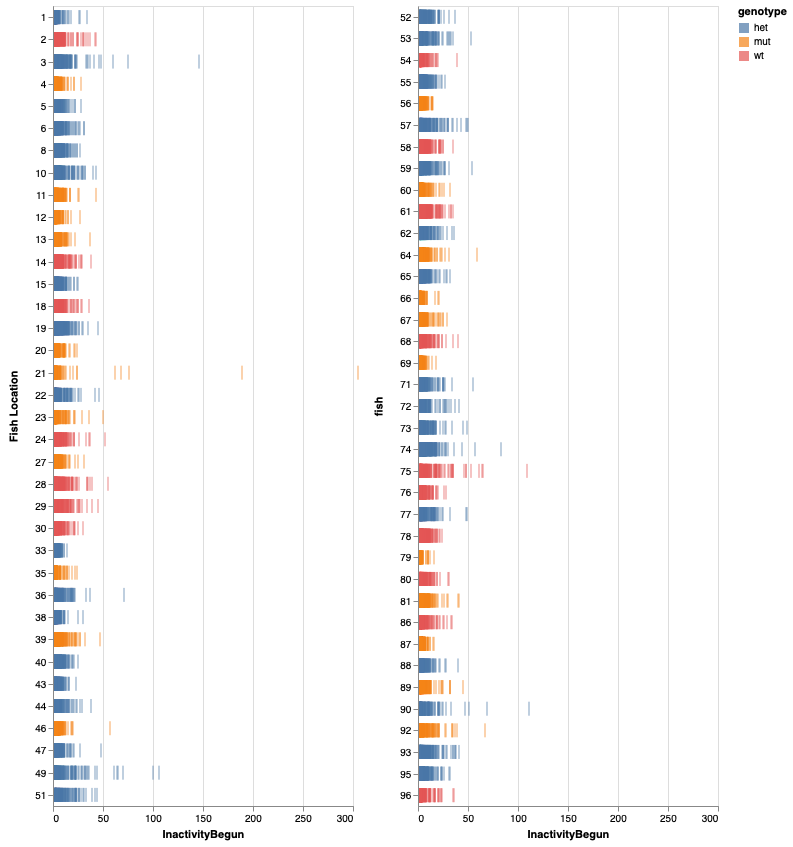

In [9]:
p1 = alt.Chart(df_inactive[df_inactive['location'] < 52], 
               width = 300, 
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', scale=alt.Scale(domain = [0, 300])),
        y=alt.Y('location:N', title='Fish Location'),
        color=alt.Color('genotype:N', title="genotype")
    )
p2 = alt.Chart(df_inactive[df_inactive['location'] >= 52], 
               width = 300,
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', scale=alt.Scale(domain = [0, 300])),
        y=alt.Y('location:N', title='fish'),
        color=alt.Color('genotype:N', title="genotype")
    )
p1 | p2

**This plot has a number of problems.** For *naps* less than ten minutes in length, the plot is completely saturated across all fish. It seems like most of the variability between the fish is within the number of longer naps. Additionally, when exploring these plots, we found that there were some outlier sleeping zebrafish. One zebrafish (at location 21) slept continuously for over 300 minutes! The remainder of the data seems to suggest that zebrafish do not normally sleep for that long, and these points threw off the scale of the graph, and prevented us from visualizing all the data within a reasonable range. Let's examine these points using the resampled data from the tutorial:

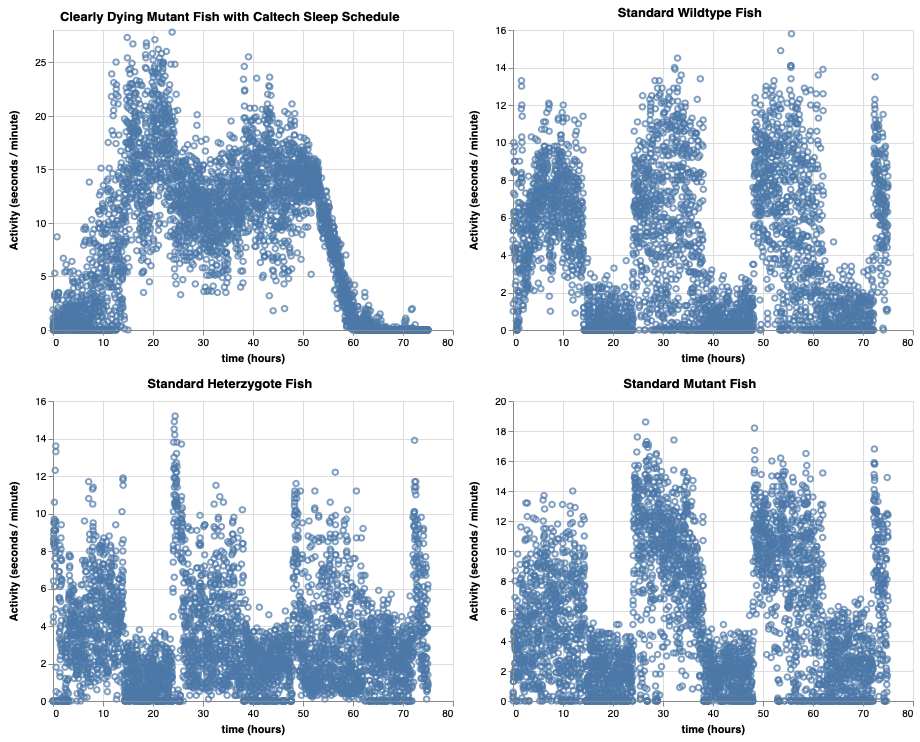

In [10]:
# I want to see what happened to the fish at location 21. Perhaps
# this fish is just an exceptional napper. 
def plot_single_fish(dataframe, location, title):
    c= alt.Chart(dataframe[df['location']==location]
        ).mark_point(
        ).encode(
            x=alt.X('zeit:Q', title='time (hours)'),
            y=alt.Y('activity:Q', title = "Activity (seconds / minute)"),
            order='zeit:Q',
        ).properties(title=title)
    return c

# I arbitrarily chose to plot fish from the first couple of wells for comparison
((plot_single_fish(df, 21, "Clearly Dying Mutant Fish with Caltech Sleep Schedule") |
  plot_single_fish(df, 2, "Standard Wildtype Fish")) &
 (plot_single_fish(df, 1, "Standard Heterzygote Fish") |
  plot_single_fish(df, 4, "Standard Mutant Fish")))

From the activity plots above, we can infer that fish 21 died mid-experiment, given that its activity patterns are erratic even in comparison to fish of similar genotype, and also given that the fish reached the end of the experiment after in-excess of 15 hours of continuous inactivity. It's possible that the mutation led to this erratic behavior, but it is not a representative fish and may be filtered out. 

We do need to set a threshold past which we will consider a zebrafish to be sleeping. This is arbitrary choice, as for any reasonable guess, there will be error for any threshold we choose, and no reasonable way to identify whether a zebrafish was sleeping or just lying still. At first we considered ten minutes, but then found that such a threshold led to an unreasonable number of sleep-deficient zebrafish. In the end we decided 5 minutes. 

In [11]:
# Define a constant 5-minute threshold
THRESH = 5

# Filter out fish 21
df = df[df['location'] != 21]

# Reset df_inactive to reflect filtering
df_inactive = df[df["InactivityBegun"] > THRESH] 

# Find the maximum sleep length left in the dataset:
m = np.max(df_inactive['InactivityBegun'].values)
print("The longest sleeping fish slept for %i minutes. " %m)

The longest sleeping fish slept for 146 minutes. 


A range from 5-146 minutes will permit us to make a much more reasonable-looking plot, even if this maximum is an outlier. Let's now examine the distribution for all the fish more spread out.

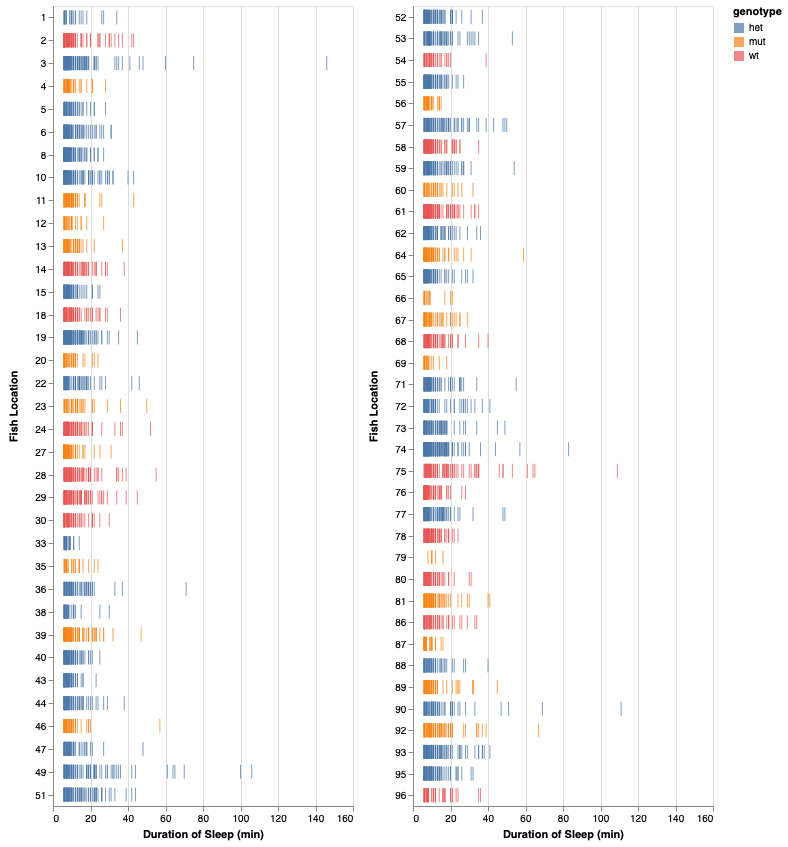

In [12]:
# Magic number 52 was chosen because it exactly splits the array of fish well locations
# into two pieces. 
p1 = alt.Chart(df_inactive[df_inactive['location'] < 52], 
               width = 300, 
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', 
                axis = alt.Axis(title='Duration of Sleep (min)'), 
                scale=alt.Scale(domain = [THRESH, 150])),
        y=alt.Y('location:N', title='Fish Location'),
        color=alt.Color('genotype:N', title="genotype")
    )
p2 = alt.Chart(df_inactive[df_inactive['location'] >= 52], 
               width = 300,
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', 
                axis = alt.Axis(title='Duration of Sleep (min)'), 
                scale=alt.Scale(domain = [THRESH, 150])),
        y=alt.Y('location:N', title='Fish Location'),
        color=alt.Color('genotype:N', title="genotype")
    )
p1 | p2

This plot is certainly a more reasonable distribution, but it is difficult to draw comparisons between genotypes without condensing the data further. 

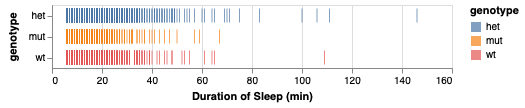

In [13]:
alt.Chart(df_inactive
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q',
                axis = alt.Axis(title='Duration of Sleep (min)')),
        y=alt.Y('genotype:N', title='genotype'),
        color=alt.Color('genotype:N', title="genotype")
    )

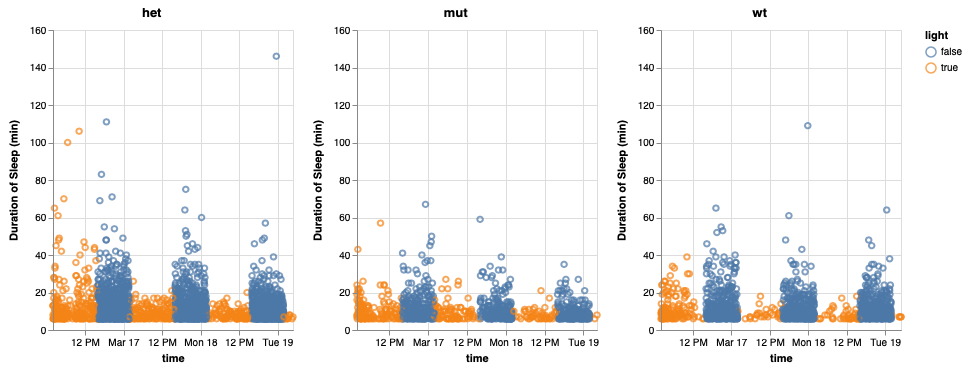

In [14]:
def get_chart(dataframe, genotype):
    return alt.Chart(dataframe[dataframe['genotype']==genotype],
                     width = 240, 
                     height = 300
                     ).mark_point(
                     ).encode(
                        x='time',
                        y=alt.Y('InactivityBegun:Q', 
                                axis = alt.Axis(title='Duration of Sleep (min)'), 
                                scale=alt.Scale(domain = [THRESH, 150])),
                        color=alt.Color('light:N', title="light")
                     ).properties(title = genotype)

get_chart(df_inactive, 'het') | get_chart(df_inactive, 'mut') | get_chart(df_inactive, 'wt')

It is clear from these plots that there are significantly more periods of inactivity in the dark than in the light. Interestingly there appears to be greater numbers of extended periods of inactivity in both light conditions in the heterozygous condition than in the other two. There also seems to be significantly less inactivity during the day in the wildtype condition than in the other two conditions. With that in mind, to get a better idea of the distribution of periods of inactivity across the genotypes in terms of length, let's plot an ECDF for length of periods of inactivity for each genotype.

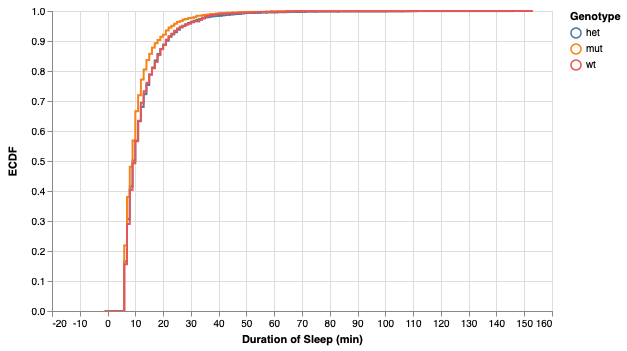

In [15]:
altcat.catplot(data=df_inactive,
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x=alt.X('InactivityBegun:Q', 
                                      axis = alt.Axis(title='Duration of Sleep (min)')),
                             color=alt.Color('genotype:N', title='Genotype')),
               transform='ecdf')

We can see from this graph that the mutant genotype has more shorter periods of inactivity ($<$20) than the other genotypes, suggesting that the mutant fish are more restless and thus sleep for shorter periods. The heterozygous and wildtype conditions appear to behave about the same. 

With this in mind, we chose to make our first parameter the average duration of uninterrupted sleep. Maintaining our previous thresholds, defining an inactive minute as a minute with <1 second of activity and a period of sleep as at least 6 minutes of inactivity, we begin by calculating the total minutes asleep in each fish and total number of sleep instances:

In [16]:
# This dictionary will store the fish location as keys, and will store
# arrays that contain cumulative sleep minutes and the number of sleep 
# instances. 
cumulative_sleeps = {}

for index, row in df_inactive.iterrows():
    location = row["location"]
    value = row["InactivityBegun"]
    
    # If we have already stored a value in cumulative_sleeps, then we
    # simply need to update this to include the additional sleep
    # instance and sleep time. 
    if location in cumulative_sleeps.keys():
        cumulative_sleeps[location] += np.array([value, 1])
        
    # Otherwise, we create an entry for the relevant fish location.
    else:
        cumulative_sleeps[location] = np.array([value, 1])
        
# convert the dictionary into a dataframe
cumulative_df = pd.DataFrame.from_dict(cumulative_sleeps, 
                                orient = 'index', 
                                columns=['cumulative_minutes_sleeping', 'wake_up_count'])

# Convert location into a column
cumulative_df['location'] = cumulative_df.index

# Merge in genotype data, using location as a common column
cumulative_df = pd.merge(cumulative_df, df_gt)

# Take a look!
cumulative_df.head()

,cumulative_minutes_sleeping,wake_up_count,location,genotype
0,297.0,25.0,1,het
1,1136.0,92.0,2,wt
2,1675.0,111.0,3,het
3,379.0,38.0,4,mut
4,552.0,53.0,5,het


This looks like it worked. Let's take a look at the data, starting with the total time slept by each fish.

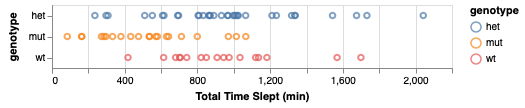

In [17]:
alt.Chart(cumulative_df).mark_point().encode(
    alt.X('cumulative_minutes_sleeping:Q', axis = alt.Axis(title='Total Time Slept (min)')),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()

This looks good! We can clearly see that the mutant fish sleep less on average than the other genotypes. The difference between the heterozygote and the wildtype are unclear due to the wide distribution. Let's take a look at the number of sleep instances for each fish.

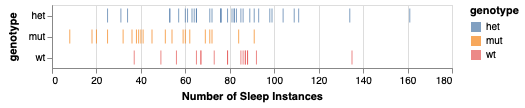

In [18]:
alt.Chart(cumulative_df).mark_tick().encode(
    alt.X('wake_up_count:Q', axis = alt.Axis(title='Number of Sleep Instances')),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()

This also looks good, we can clearly see that the mutant fish went to sleep less often than fish of the other two genotypes. This suggests that the mutant fish slept less because they slept less often, not just because the slept for shorter periods of time. To get a better sense of how long they slept and arrive at a meaningful parameter, let's calculate the average duration of uninterrupted sleep using the two parameters we just calculated.

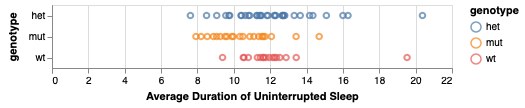

In [19]:
cumulative_df['average_sleep_length']= cumulative_df['cumulative_minutes_sleeping']/cumulative_df['wake_up_count']

alt.Chart(cumulative_df).mark_point().encode(
    alt.X('average_sleep_length:Q', axis = alt.Axis(title='Average Duration of Uninterrupted Sleep')),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()

This looks great! It's easy to observe that the mutant fish have a lower average duration of uninterrupted sleep. The heterozygous fish have a greater distribution of average durations than the wildtype fish, but appear to have around the same average. Let's now calculate the average duration of uninterrupted sleep for all fish of each genotype, to arrive at a definite parameter.

In [20]:
wt_df = cumulative_df[cumulative_df["genotype"]=="wt"]
mut_df = cumulative_df[cumulative_df["genotype"]=="mut"]
het_df = cumulative_df[cumulative_df["genotype"]=="het"]
print("The average duration of uninterrupted sleep for wildtype fish is %.2f minutes." 
      % np.average(wt_df["average_sleep_length"].values))
print("The average duration of uninterrupted sleep for heterozygote fish is %.2f minutes." 
      % np.average(het_df["average_sleep_length"].values))
print("The average duration of uninterrupted sleep for mutant fish is %.2f minutes." 
      % np.average(mut_df["average_sleep_length"].values))

The average duration of uninterrupted sleep for wildtype fish is 12.12 minutes.
The average duration of uninterrupted sleep for heterozygote fish is 12.11 minutes.
The average duration of uninterrupted sleep for mutant fish is 10.48 minutes.


We can see a clear decrease in duration of uninterrupted sleep for the mutant fish versus the other fish. The average durations for the wildtype and heterozygote fish are nearly identical, suggesting the fish are behaving similarly. This difference suggests that the mutant fish are more restless and not sleeping for as long as the other fish. 

Now we want to analyze the sleep cycle of fish of each genotype by comparing the total sleep duration in the light condition versus the dark condition for each fish. We refactored the code for cumulative sleep to factor in the light and dark conditions.

In [21]:
cumulative_sleeps = {}

for index, row in df_inactive.iterrows():
    location = row["location"]
    value = row["InactivityBegun"]
    if location in cumulative_sleeps.keys():
        if row["light"]:
            cumulative_sleeps[location] += np.array([value, 0, 1])
        else:
            cumulative_sleeps[location] += np.array([0, value, 1])
    else:
        if row["light"]:
            cumulative_sleeps[location] = np.array([value, 0, 1])
        else:
            cumulative_sleeps[location] = np.array([0, value, 1])
ld_df = pd.DataFrame.from_dict(cumulative_sleeps, 
                                orient = 'index', 
                                columns=['cumulative_minutes_sleeping_light', 
                                         'cumulative_minutes_sleeping_dark',
                                         'wake_up_count'])
ld_df['location'] = ld_df.index
cumulative_df = pd.merge(ld_df, cumulative_df)

cumulative_df["light/dark"] = cumulative_df["cumulative_minutes_sleeping_light"] \
                            / cumulative_df["cumulative_minutes_sleeping_dark"]
cumulative_df.head()

,cumulative_minutes_sleeping_light,cumulative_minutes_sleeping_dark,wake_up_count,location,cumulative_minutes_sleeping,genotype,average_sleep_length,light/dark
0,97.0,200.0,25.0,1,297.0,het,11.880000,0.485000
1,67.0,1069.0,92.0,2,1136.0,wt,12.347826,0.062675
2,377.0,1298.0,111.0,3,1675.0,het,15.090090,0.290447
3,64.0,315.0,38.0,4,379.0,mut,9.973684,0.203175
4,116.0,436.0,53.0,5,552.0,het,10.415094,0.266055


This looks like it worked, let's get a better look at the data:

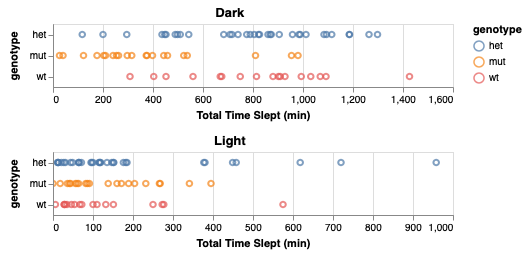

In [22]:
dark_chart = alt.Chart(cumulative_df).mark_point().encode(
    alt.X('cumulative_minutes_sleeping_dark:Q', axis = alt.Axis(title='Total Time Slept (min)')),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).properties(title = "Dark").interactive()

light_chart = alt.Chart(cumulative_df).mark_point().encode(
    alt.X('cumulative_minutes_sleeping_light:Q', axis = alt.Axis(title='Total Time Slept (min)')),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).properties(title = "Light").interactive()

dark_chart & light_chart

There is clearly higher amounts of sleep for all fish in the dark than in the light. In the dark condition we see lower amounts of sleep for the mutant fish than the other fish, which fits our expectations from the previous parameter. However, in the light condition it's not obvious, as differences between genotypes are difficult to discern. To compare the two conditions we decided to calculate the ratio of total time slept in the light to total time slept in the dark, with the expectation that mutants would have a much higher ratio, given that they are expected to have an irregular sleep pattern.

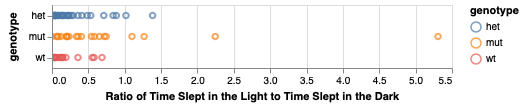

In [23]:
alt.Chart(cumulative_df).mark_point().encode(
    alt.X('light/dark:Q', axis = alt.Axis(title='Ratio of Time Slept in the Light to Time Slept in the Dark')),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()

It's a bit difficult to see the differences between the three genotypes in this chart format, they all seem to have similarly low ratios. To get a better sense of the differences we decided to plot an ECDF of the same data.

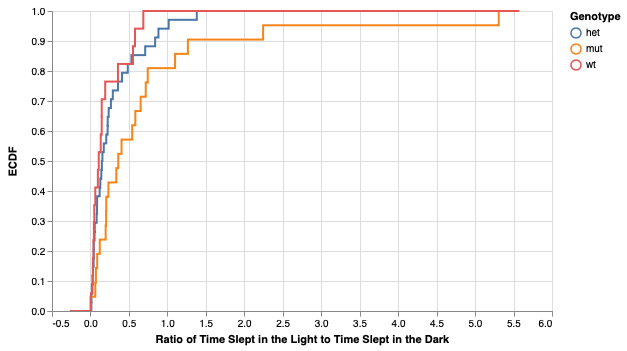

In [24]:
altcat.catplot(data=cumulative_df,
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x=alt.X('light/dark:Q', 
                                     axis = alt.Axis(title='Ratio of Time Slept in the Light to Time Slept in the Dark')),
                             color=alt.Color('genotype:N', title='Genotype')),
               transform='ecdf')

Finally, we have discovered that the circadian rhythms of mutant fish are clearly less stable than those for wildtype fish, as evidenced by more sleep during daytime and less sleep during night time. We would like to finish our parametrization with actual numbers. Glancing at the distribution, it seems that taking a median will result in the especially irregular fish biasing the data less. 

In [25]:
wt_df = cumulative_df[cumulative_df["genotype"]=="wt"]
mut_df = cumulative_df[cumulative_df["genotype"]=="mut"]
het_df = cumulative_df[cumulative_df["genotype"]=="het"]
print("The median ratio of time slept in light versus time slept in the dark for wildtype fish is %.2f." 
      % np.median(wt_df["light/dark"].values))
print("The median ratio of time slept in light versus time slept in the dark for heterozygote fish is %.2f." 
      % np.median(het_df["light/dark"].values))
print("The median ratio of time slept in light versus time slept in the dark for mutant fish is %.2f." 
      % np.median(mut_df["light/dark"].values))

The median ratio of time slept in light versus time slept in the dark for wildtype fish is 0.11.
The median ratio of time slept in light versus time slept in the dark for heterozygote fish is 0.15.
The median ratio of time slept in light versus time slept in the dark for mutant fish is 0.36.


The significantly higher media ratio of time slept in the light versus the dark in the mutant fish than the others suggests that the mutant fish have a more irregular sleep cycle than the other fish, which is to be expected because the mutants do not have the enzyme required for the rhythmic production of melatonin, which is responsible for the regulation of circadian rhythm. There is greater than twofold increase in the ratio for the mutant fish versus the other. Taken together, these parametrizations display the differences seen in the mutants in both overall sleep behavior and also highlight the irregularities in rhythmic behaviors. In short, much like a Caltech student, they sleep little, irregularly, and with little regard for time of day. 